# Fully Connected Network and Data Loading

In [1]:
import torch
import numpy as np
import random, datetime
import matplotlib.pyplot as plt

Create here a small example set of points we want to classify.  Values with $y > \cos^2\left(\frac{1}{2}\pi x\right)$ will be considered red, otherwise blue.  We'll construct a neural network to predict blue/red values.

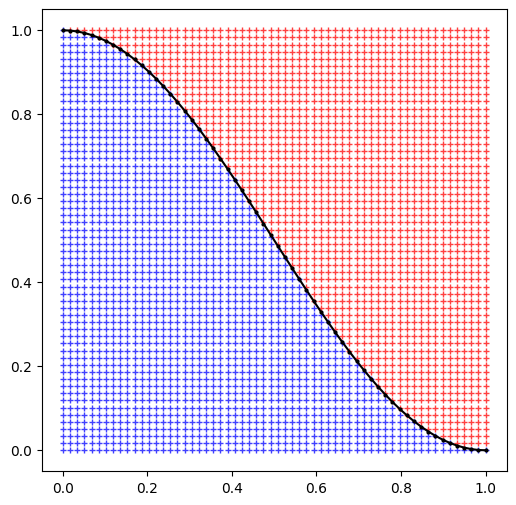

In [2]:
N = 60
r = np.linspace(0, 1, N)
x, y = np.meshgrid(r, r); x = x.flatten(); y = y.flatten();

red_vals = y - np.cos(0.5*x*np.pi)**2 > 0
plt.figure(figsize=(6,6))
plt.plot(x[red_vals],y[red_vals],'r+',markersize=5,alpha=0.75)
plt.plot(x[np.logical_not(red_vals)],y[np.logical_not(red_vals)],'b+',markersize=5,alpha=0.75)
plt.plot(r, np.cos(0.5*r*np.pi)**2, 'ko-', markersize=2)

Create a nice representation of our data using PyTorch's Dataset class:

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, values):
        # Load the data here!
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        self.xy = torch.column_stack((x,y)) # Combine x,y data into Nx2 tensor
        self.values = torch.Tensor(values).reshape((-1,1)) # Convert values into an Nx1 tensor
        
    def __len__(self):
        return self.xy.shape[0]
    
    def __getitem__(self, idx):
        return {
            'xy': self.xy[idx],
            'values': self.values[idx]
        }

In [4]:
true_vals = torch.Tensor([1 if i == True else -1 for i in red_vals])
true_vals

tensor([-1., -1., -1.,  ...,  1.,  1.,  1.])

In [5]:
data = Dataset(x, y, true_vals)

This can be indexed like a normal array

In [6]:
data[3]

{'xy': tensor([0.0508, 0.0000]), 'values': tensor([-1.])}

Slicing works, too

In [7]:
data[::300]

{'xy': tensor([[0.0000, 0.0000],
         [0.0000, 0.0847],
         [0.0000, 0.1695],
         [0.0000, 0.2542],
         [0.0000, 0.3390],
         [0.0000, 0.4237],
         [0.0000, 0.5085],
         [0.0000, 0.5932],
         [0.0000, 0.6780],
         [0.0000, 0.7627],
         [0.0000, 0.8475],
         [0.0000, 0.9322]]),
 'values': tensor([[-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.],
         [-1.]])}

PyTorch has built-ins for sampling minibatches of the dataset.  This will automatically combine our sample data for us!

In [8]:
batches = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True)
next(iter(batches))

{'xy': tensor([[0.4576, 0.0339],
         [0.0169, 0.1864],
         [0.9831, 0.7797],
         [0.4407, 0.2034],
         [1.0000, 0.7119],
         [0.2881, 0.5424],
         [0.5424, 0.2203],
         [1.0000, 0.8136],
         [0.0508, 0.4068],
         [0.3051, 0.6441]]),
 'values': tensor([[-1.],
         [-1.],
         [ 1.],
         [-1.],
         [ 1.],
         [-1.],
         [-1.],
         [ 1.],
         [-1.],
         [-1.]])}

We'll go ahead and create the neural network class.  Note that we can combine layers using a `Sequential` module.

In [9]:
# Can find a helpful list of the neural network modules at https://pytorch.org/docs/stable/nn.html

class FCN(torch.nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        N = 20
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(2, N), torch.nn.ReLU(),
            torch.nn.Linear(N, N), torch.nn.ReLU(),
            torch.nn.Linear(N, 1), torch.nn.Tanh()
        )

    def forward(self, xy):
        # Forward propagation
        return self.fc_layers(xy)

In [10]:
net = FCN()
opt = torch.optim.Adam(net.parameters(), lr=0.01)
loss_history = []

The `DataLoader` class from above can be used to split the dataset into batches.

Final loss value 0.32799580693244934


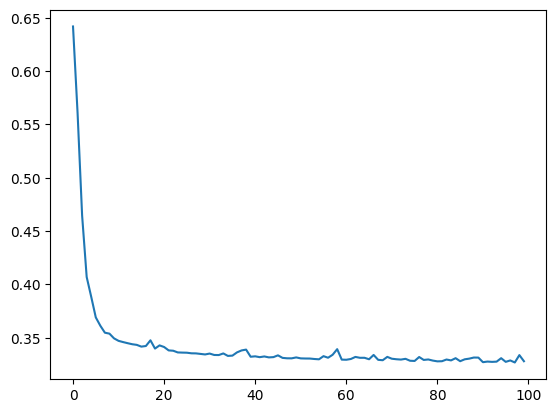

In [11]:
num_epochs = 100
batch_size = 500
loss_fn = torch.nn.SoftMarginLoss()

for i in range(num_epochs):
    batches = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    for batch in batches:
        opt.zero_grad()
        predicted = net(batch['xy'])
        loss = loss_fn(predicted, batch['values'])
        loss.backward()
        opt.step()

    full_loss = loss_fn(net(data.xy), data.values)
    loss_history.append(full_loss.item())

plt.plot(loss_history)
print('Final loss value', loss_history[-1])

Lets see our predictions:

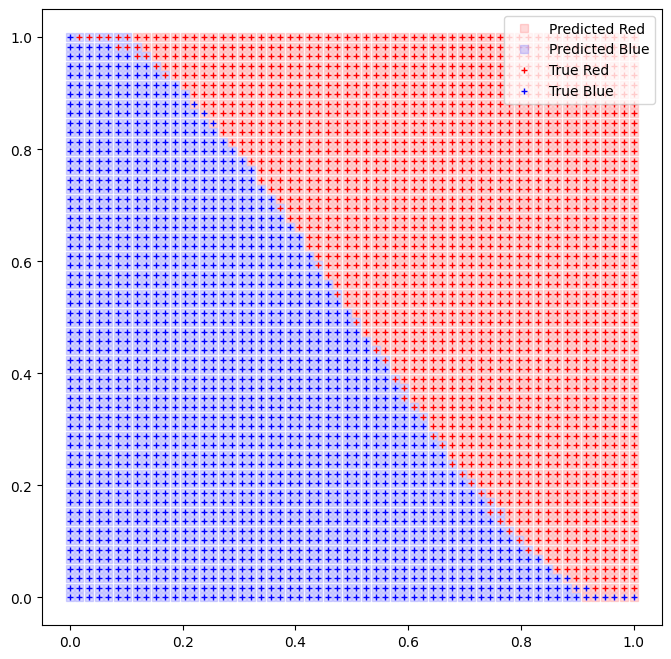

In [12]:
plt.figure(figsize=(8,8))

pred_red = (np.array(net(data.xy).detach().numpy()) > 0).flatten()
plt.plot(x[pred_red],y[pred_red],'rs',markersize=6,alpha=0.15, label='Predicted Red')
plt.plot(x[np.logical_not(pred_red)],y[np.logical_not(pred_red)],'bs',markersize=6,alpha=0.15, label='Predicted Blue')

plt.plot(x[red_vals],y[red_vals],'r+',markersize=5, label='True Red')
plt.plot(x[np.logical_not(red_vals)],y[np.logical_not(red_vals)],'b+',markersize=5, label='True Blue')
plt.legend()